In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,80]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True


In [4]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True


## Show a map for the subset region

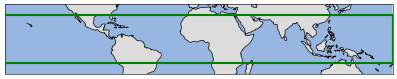

In [5]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [6]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 4672, times: 500, nmaxpf: 3, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4668 4669 4670 4671
  * times                    (times) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4672), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4672), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4672, 500, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4672, 500, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4672, 500), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [7]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5093, times: 600, nmaxpf: 3, source: 8)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5089 5090 5091 5092
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm5' 'm6' 'm7'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5093), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5093), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5093, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5093, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5093, 600), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Sat Oct 28 13:39:41 2023

In [8]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 80])

In [9]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

In [10]:
# Get global attributes
pixel_radius = ds_pyflex.attrs['pixel_radius_km']
time_resolution = ds_pyflex.attrs['time_resolution_hour']

In [11]:
def find_tracks_start(ds_in):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )
    return ds_out

def get_land_ocean_ds(ds_in):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [12]:
dss_pyflex = find_tracks_start(ds_pyflex)

In [13]:
dss_moaap = find_tracks_start(ds_moaap)

In [14]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2514
ARPEGE: 772
IFS: 2406
MPAS: 1192
NICAM: 2769
SAM: 2631
UM: 1586
FV3: 2049


In [15]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2187
ARPEGE: 191
IFS: 2560
MPAS: 1564
NICAM: 2059
SAM: 972
UM: 1464
FV3: 1682


In [16]:
# print(f'Number of MCS (MOAAP)')
# for key in ds_moaap['source'].data:
#     ntracks = np.count_nonzero(ds_moaap.track_duration.sel(source=key) > 0)
#     print(f'{name_map[key]}: {ntracks}')

## Separate land vs. ocean MCS

In [17]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [18]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

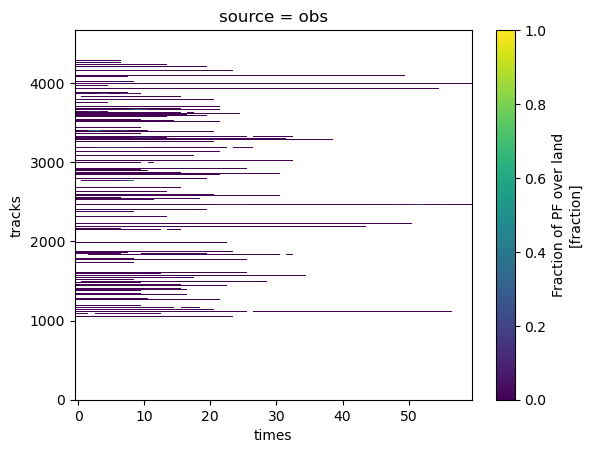

In [19]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

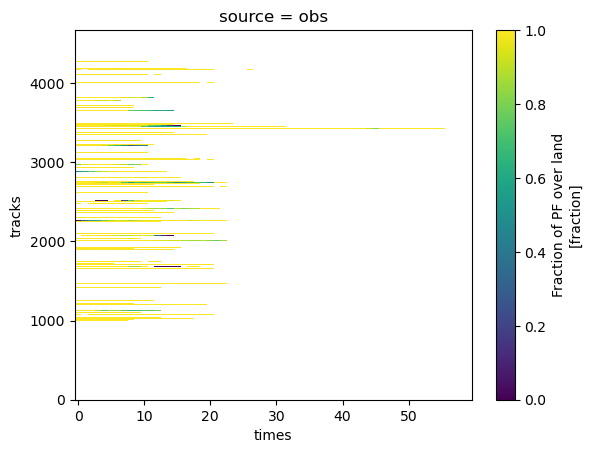

In [20]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [21]:
# TODO: use a simple method to separate possible merge/split tracks
# E.g., if max CCS area occur within the first 10% of a tracks start time: split; or within last 10% of a tracks end time: merge
# ds.ccs_area.max(dim='times')

In [22]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

### CCS lifetime

In [23]:
da_tmp = (dss_pyflex_l.track_duration * dss_pyflex_l.attrs['time_resolution_hour']).transpose()
ccslifetime_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.track_duration * dss_pyflex_o.attrs['time_resolution_hour']).transpose()
ccslifetime_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [24]:
da_tmp = (dss_moaap_l.track_duration * dss_moaap_l.attrs['time_resolution_hour']).transpose()
ccslifetime_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.track_duration * dss_moaap_o.attrs['time_resolution_hour']).transpose()
ccslifetime_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [25]:
ccslifetime_pyflex_o

,OBS,ARPEGE,IFS,MPAS,NICAM,SAM,UM,FV3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4667,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
4668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 60.0)

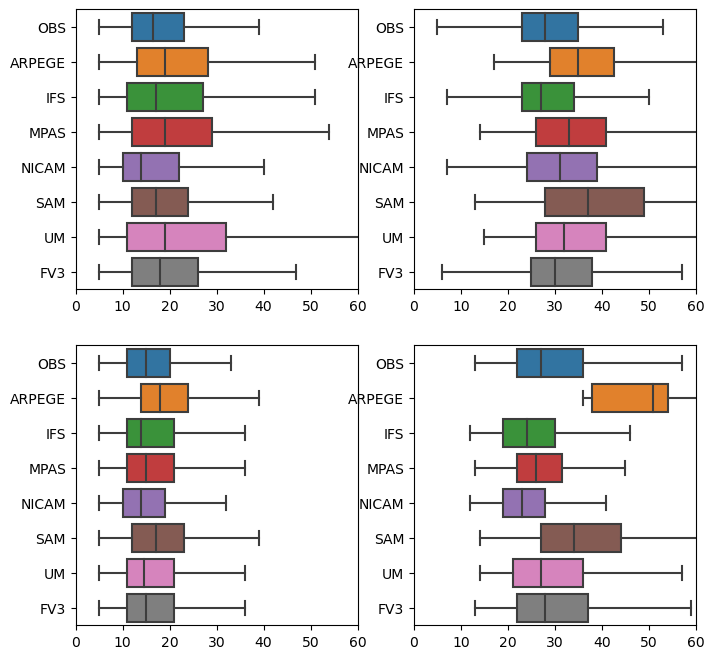

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=ccslifetime_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=ccslifetime_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(0,60)
axes[1][0].set_xlim(0,60)
axes[0][1].set_xlim(0,60)
axes[1][1].set_xlim(0,60)
# axes[0][0].set_title('')

### Max CCS area

In [27]:
da_tmp = np.log10(dss_pyflex_l.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = np.log10(dss_pyflex_o.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [28]:
da_tmp = np.log10(dss_moaap_l.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = np.log10(dss_moaap_o.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

(4.5, 6.8)

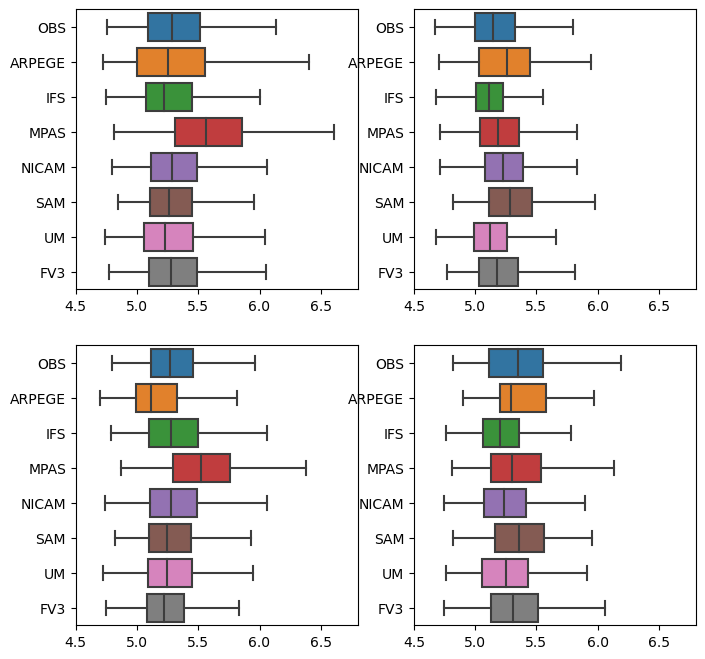

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=maxccsarea_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=maxccsarea_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=maxccsarea_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=maxccsarea_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(4.5,6.8)
axes[1][0].set_xlim(4.5,6.8)
axes[0][1].set_xlim(4.5,6.8)
axes[1][1].set_xlim(4.5,6.8)

### Lifetime-average min Tb

In [30]:
da_tmp = (dss_pyflex_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [31]:
da_tmp = (dss_moaap_l.corecold_mintb.mean(dim='times')).transpose()
avgmintb_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.corecold_mintb.mean(dim='times')).transpose()
avgmintb_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

(180.0, 225.0)

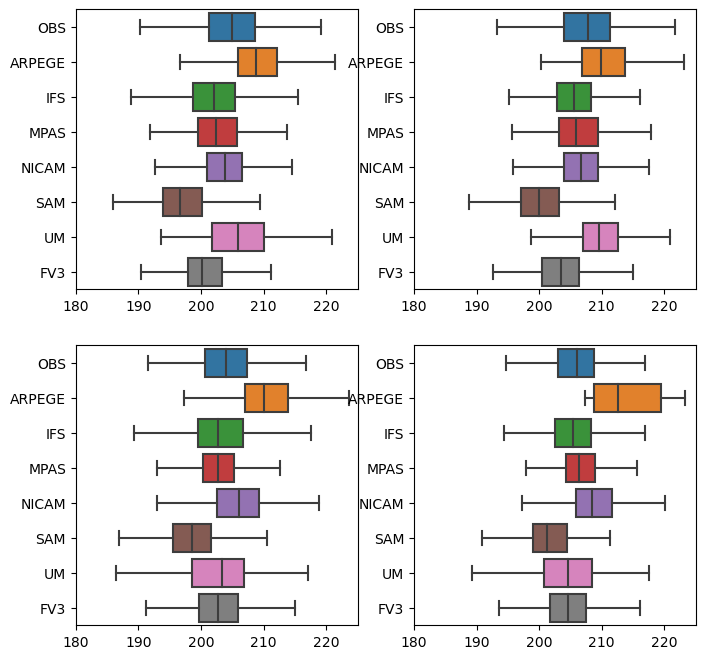

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=avgmintb_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=avgmintb_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=avgmintb_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=avgmintb_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(180,225)
axes[1][0].set_xlim(180,225)
axes[0][1].set_xlim(180,225)
axes[1][1].set_xlim(180,225)

### Total volume rain

In [33]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

da_tmp = (dss_pyflex_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())
# pfvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)

da_tmp = (dss_pyflex_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())
# pfvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)

In [34]:
da_tmp = (dss_moaap_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())
# pfvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)

da_tmp = (dss_moaap_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())
# pfvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)

In [35]:
# Convert to log10, and replace -inf with NaN
log10pfvolrain_pyflex_o = np.log10(pfvolrain_pyflex_o)
log10pfvolrain_pyflex_l = np.log10(pfvolrain_pyflex_l)
log10pfvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_moaap_o = np.log10(pfvolrain_moaap_o)
log10pfvolrain_moaap_l = np.log10(pfvolrain_moaap_l)
log10pfvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)

(5.0, 8.0)

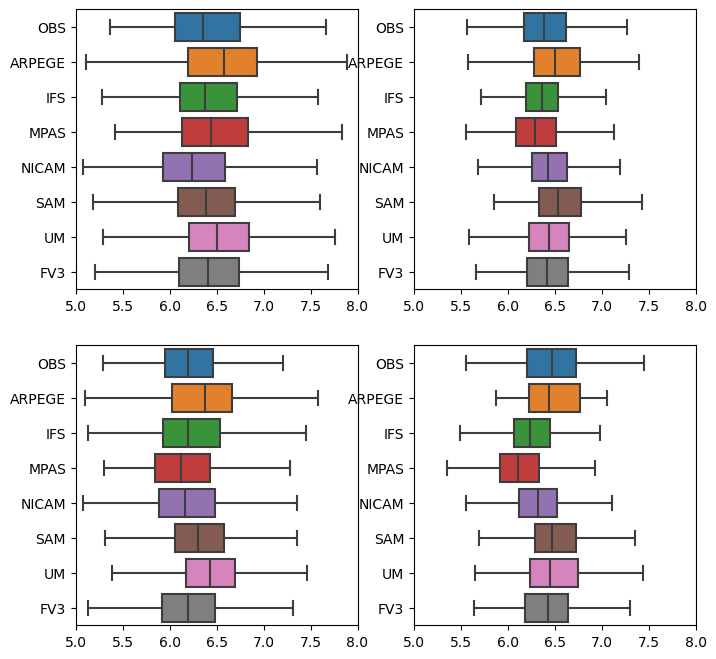

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=log10pfvolrain_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(5,8)
axes[1][0].set_xlim(5,8)
axes[0][1].set_xlim(5,8)
axes[1][1].set_xlim(5,8)

### Heavy rain volume

In [37]:
da_tmp = (dss_pyflex_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [38]:
da_tmp = (dss_moaap_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [39]:
# # Convert to log10, and replace -inf with NaN
# log10pfheavyvolrain_pyflex_o = np.log10(pfheavyvolrain_pyflex_o)
# log10pfheavyvolrain_pyflex_l = np.log10(pfheavyvolrain_pyflex_l)
# pfheavyvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)
# pfheavyvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)

# log10pfheavyvolrain_moaap_o = np.log10(pfheavyvolrain_moaap_o)
# log10pfheavyvolrain_moaap_l = np.log10(pfheavyvolrain_moaap_l)
# pfheavyvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)
# pfheavyvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)

### Heavy rain volume ratio

In [40]:
pfhrr_pyflex_l = 100 * pfheavyvolrain_pyflex_l / pfvolrain_pyflex_l
pfhrr_pyflex_o = 100 * pfheavyvolrain_pyflex_o / pfvolrain_pyflex_o

pfhrr_moaap_l = 100 * pfheavyvolrain_moaap_l / pfvolrain_moaap_l
pfhrr_moaap_o = 100 * pfheavyvolrain_moaap_o / pfvolrain_moaap_o

In [41]:
# Convert to log10, and replace -inf with NaN
log10pfhrr_pyflex_o = np.log10(pfhrr_pyflex_o)
log10pfhrr_pyflex_l = np.log10(pfhrr_pyflex_l)
pfhrr_pyflex_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_pyflex_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_moaap_o = np.log10(pfhrr_moaap_o)
log10pfhrr_moaap_l = np.log10(pfhrr_moaap_l)
pfhrr_moaap_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_moaap_o.replace(-np.inf, np.nan, inplace=True)

(0.0, 100.0)

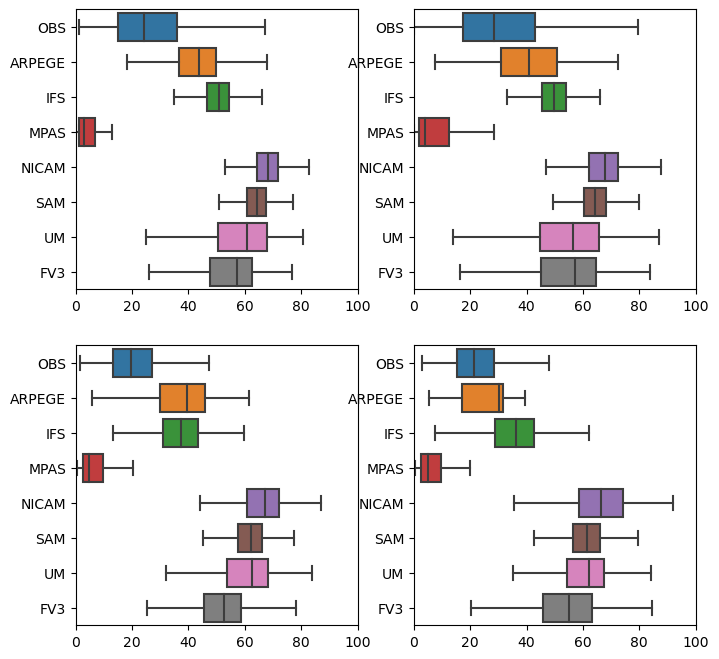

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=pfhrr_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=pfhrr_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=pfhrr_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=pfhrr_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(0,100)
axes[1][0].set_xlim(0,100)
axes[0][1].set_xlim(0,100)
axes[1][1].set_xlim(0,100)

### Mean PF rain rate

In [43]:
da_tmp = (dss_pyflex_l.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [44]:
da_tmp = (dss_moaap_l.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.pf_rainrate.isel(nmaxpf=0).mean(dim='times')).transpose()
meanpfrainrate_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

(2.0, 20.0)

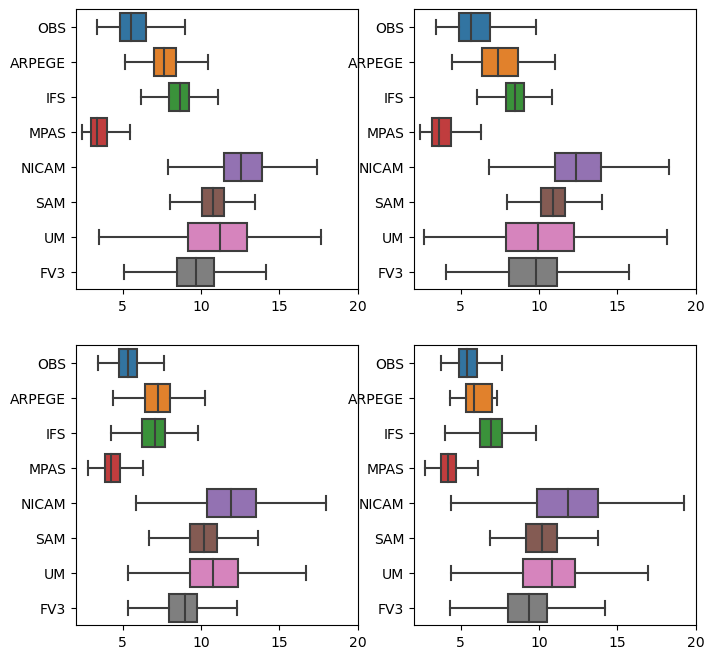

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.boxplot(data=meanpfrainrate_pyflex_o, orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_pyflex_l, orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_o, orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_l, orient='h', ax=axes[1][1], showfliers=False)
axes[0][0].set_xlim(2,20)
axes[1][0].set_xlim(2,20)
axes[0][1].set_xlim(2,20)
axes[1][1].set_xlim(2,20)

## Function to plot mirror box plot on (m x n) panels

In [46]:
def boxplot_mirror_mxn(nrow, ncol, data_top, data_bot, titles, xlabels, legends, figname,  
                        map_show=False, map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0], map_bottop='top', panel_colors=None,
                        legend_fontsize=11, legend_loc='best', label_topbot=None, legend_ncol=None, figsize=[10,10], fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.15, hspace=0.3)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.3, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.3, hspace=0)

    lcolors = {
        'obs': 'gray', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    lw = 1.5
    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    pcolors = list(lcolors.values())[:data_top[0][0].shape[1]]
    notch = False

    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1)
        ax2.invert_yaxis()
        # ax1.xaxis.set_ticklabels([])
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            # ax1.legend(fontsize=legend_fontsize, loc=legend_loc, ncols=legend_ncol)


        # Plot inset map
        if (map_show):
            if (row == map_panel[0]) & (col == map_panel[1]):
                if map_bottop == 'top':
                    ax_map = ax1
                if map_bottop == 'bot':
                    ax_map = ax2
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax_map, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)
                
    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1)
        ax2.invert_yaxis()
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            
        fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

### Set up legends, inset map

In [47]:
# Inset map settings
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-180, 179, -35, 50], [-180, 179], [-15, 30])

/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

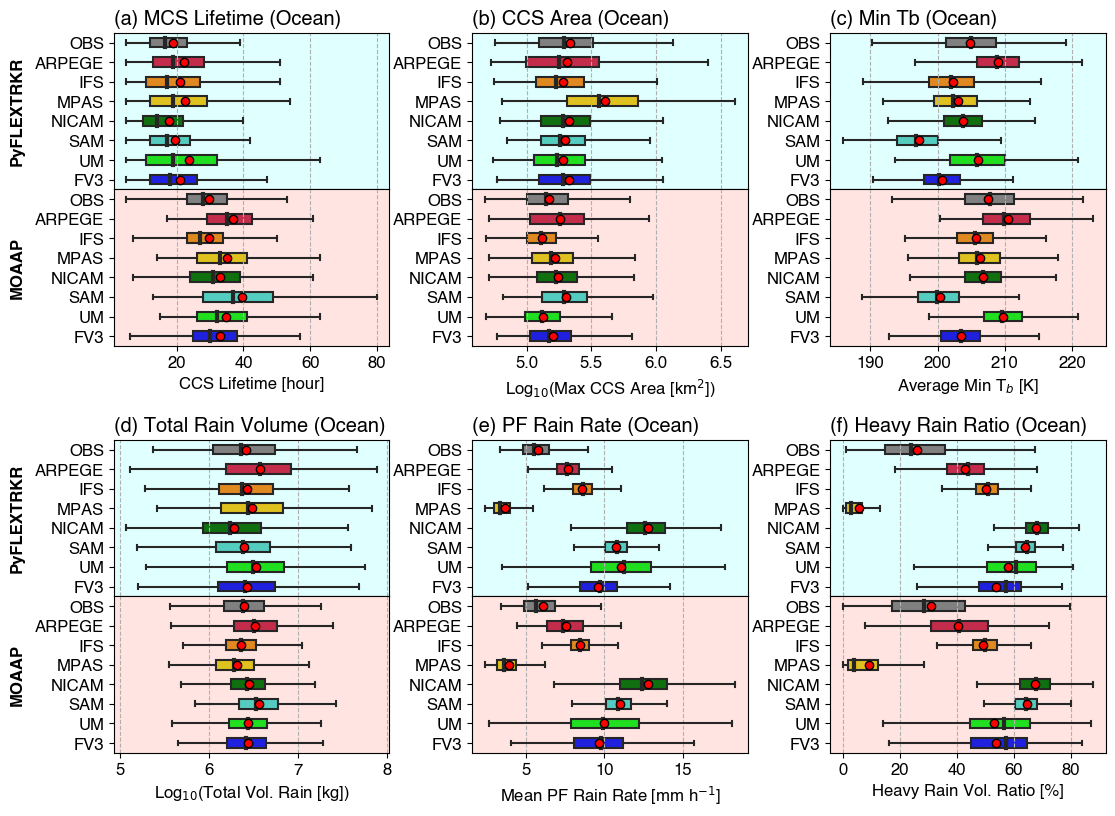

In [48]:
data_top = [
    [ccslifetime_pyflex_o, maxccsarea_pyflex_o, avgmintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_moaap_o, maxccsarea_moaap_o, avgmintb_moaap_o, ],
    [log10pfvolrain_moaap_o, meanpfrainrate_moaap_o, pfhrr_moaap_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_1351184/913225336.py:94: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykern

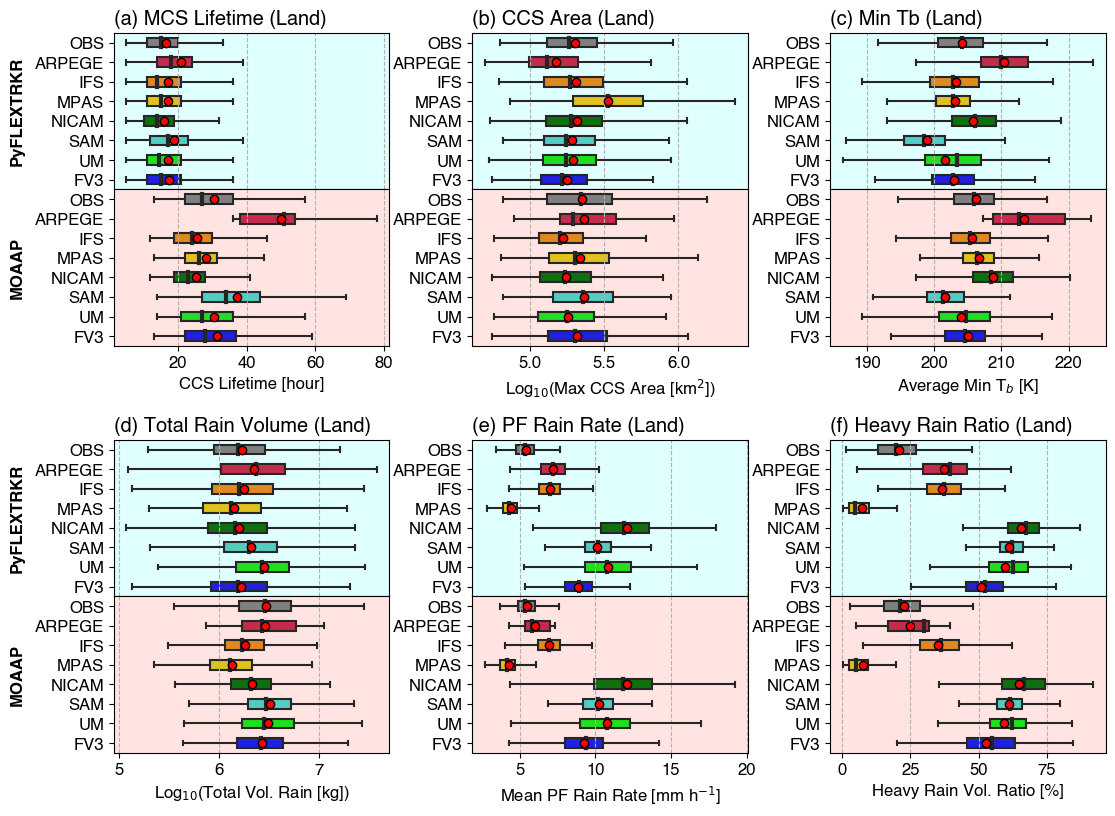

In [49]:
data_top = [
    [ccslifetime_pyflex_l, maxccsarea_pyflex_l, avgmintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_moaap_l, maxccsarea_moaap_l, avgmintb_moaap_l, ],
    [log10pfvolrain_moaap_l, meanpfrainrate_moaap_l, pfhrr_moaap_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 12
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

In [50]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/boxwhisker_mcs_land_2x3_PyFLEXTRKR_MOAAP.png'